Este notebook busca implementar una red neuronal de tipo deconvolucional para obtener las primeras salidas. Los datos utilizados fueron obtenidos mediante el código del archivo: ```Sivar_as_functions.py```.

Para trabajar con los datos, crearemos una variable que contenga los parches asociados a cada caso (es decir, a cada carpeta) ya que se detectó, durante el proceso de cortado, que habían casos con 121 registros temporales y otros únicamente con 120. La estructura de la variable que contendrá toda la información será un diccionario anidado cuya key principal será la variable meteorológica respectiva y su diccionario interno contendrá dicha información para cada uno de los caso. Por ejemplo: 
```
stack= { "wspd_wdir10" : { "caso_1" : valores, "caso_2", valores, ... , "caso_n": valores} },
          "HGT"        : { "caso_1" : valores, "caso_2: valores, ..., "caso_n": valores}}
          ... , 
       {  "times", {...}}
```

Cabe mencionar que el pipeline utilizado está estrictamente basado en un trabajo anterior en el cual se implementó una red de tipo residual para el *downscaling* de temperatura.

>> Pequeño disclaimer: El código implementado no está diseñado especificamente para la variable de viento ni tampoco ha sido corregido con las últimas observaciones. Sin embargo, como lo que se requiere es obtener las primeras salidas, se utilizará de todas maneras.

Nota: un detalle interesante es que la variable ```times``` contiene un valor constante repetido y no es un tensor como tal (aún).

##### Creación del stack

Trabajaremos con 5 variables: ```["wspd_wdir10_0","HGT", "XLAT","XLONG","times" ]```. 
- wspd_wdir10_0: velocidad del viento. 
- "HGT: terrain height
- XLAT: latitud
- XLONG: longitud
- times: registro temporal asociado.

Es importante aclarar que cada caso contiene tanto los valores del dominio d03 como d05. Más en específico, los primeros 120 archivos corresponden al dominio d03 y los 120 restantes al dominio d05.


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 
import os 

path="./salidas_parche_big03/" #Carpeta que contiene la info
variables=["wspd_wdir10_0", "wspd_wdir10_1", "HGT", "XLAT","XLONG","times" ] #también son los nombres de las subcarpetas
casos=['2016_05_01', '2016_12_13', '2018_03_21', '2020_01_16', '2020_01_31'] #fecha de los casos

In [2]:
%%time

stack= {key: '' for key in variables} #dic. con toda la información

for var in variables:
    stack_casos= {key: '' for key in casos} #dic con la informacion de cada caso
    for caso in casos: 
        rutas_npys=path + var + "/" + caso #ruta de la carpeta donde se encuentran los archivos a importar
        archivos= os.listdir(rutas_npys) #lista con los archivos
        archivos_npy = [archivo for archivo in archivos if archivo.endswith('.npy')] #filtrado de .npy

        parches_npy=[] 

        if not len(archivos_npy) == 240: #eliminamos el último registro temporal de cada dominio
            archivos_npy.pop(-1)
            archivos_npy.pop(120)

        for archivo_npy in archivos_npy: #cargamos todos los archivos .npy
            ruta=os.path.join(rutas_npys, archivo_npy)
            parche= np.load(ruta)
            parches_npy.append(parche)


        if var != 'times': #la variable times requiere un tratamiento especial al ser una ctte.
            stack_casos[caso] = tf.convert_to_tensor(parches_npy)
        else:
            stack_casos[caso] = parches_npy

    print(f"variable {var} lista")

    stack[var] = stack_casos #guardamos el dic con los casos en su respectiva key

variable wspd_wdir10_0 lista
variable wspd_wdir10_1 lista
variable HGT lista
variable XLAT lista
variable XLONG lista
variable times lista
CPU times: total: 15.6 s
Wall time: 1min 58s


In [3]:
for var in variables:
    print(f"Para {var}")
    for caso in casos:
        if var != "times":
            print(f"Dimensiones caso {caso}: ", stack[var][caso].shape)
        else:
            print(f"Dimensiones times: ",len(stack[var][caso]))

Para wspd_wdir10_0
Dimensiones caso 2016_05_01:  (240, 1, 156, 32, 32)
Dimensiones caso 2016_12_13:  (240, 1, 156, 32, 32)
Dimensiones caso 2018_03_21:  (240, 1, 156, 32, 32)
Dimensiones caso 2020_01_16:  (240, 1, 156, 32, 32)
Dimensiones caso 2020_01_31:  (240, 1, 156, 32, 32)
Para wspd_wdir10_1
Dimensiones caso 2016_05_01:  (240, 1, 156, 32, 32)
Dimensiones caso 2016_12_13:  (240, 1, 156, 32, 32)
Dimensiones caso 2018_03_21:  (240, 1, 156, 32, 32)
Dimensiones caso 2020_01_16:  (240, 1, 156, 32, 32)
Dimensiones caso 2020_01_31:  (240, 1, 156, 32, 32)
Para HGT
Dimensiones caso 2016_05_01:  (240, 1, 156, 32, 32)
Dimensiones caso 2016_12_13:  (240, 1, 156, 32, 32)
Dimensiones caso 2018_03_21:  (240, 1, 156, 32, 32)
Dimensiones caso 2020_01_16:  (240, 1, 156, 32, 32)
Dimensiones caso 2020_01_31:  (240, 1, 156, 32, 32)
Para XLAT
Dimensiones caso 2016_05_01:  (240, 1, 156, 32, 32)
Dimensiones caso 2016_12_13:  (240, 1, 156, 32, 32)
Dimensiones caso 2018_03_21:  (240, 1, 156, 32, 32)
Dimensi

#### Compatibilización de las variables:

Al completar el proceso de importación de los datos, se pudo observar que cada carpeta contiene 120 registros temporales, y cada registro temporal tiene asociado 156 parches de tamaño 32 x 32. Esto da un total de 18720 parches por caso, y 93600 parches en total para cada variable. Sin embargo, la arquitectura a implementar exige que los parches sean de la forma (n,3,32,32,1) donde $n$ es la cantidad de parches para cada variable. Para lograr esta compatibilización, se implementará el método ```tf.reshape```de tensorflow que permite permutar las dimensiones de un tensor, en este caso lo que haremos es unificar a través de una concatenación los 156 parches asociado a los 120 registros temporales y luego concatenar nuevamente para cada uno de los casos. A través de este método lo que se obtiene es un tensor de dimensiones (93600, 1, 32, 32, 1) para cada variable a utilizar. 

In [4]:
def reshape_tensor(var, stack, caso=casos, input=False):

    bloque= tf.zeros([1, 1, 32, 32, 1], dtype=tf.float32)
    for caso in casos:
        valores= stack[var][caso][120:] if not input else stack[var][caso][:120] 
        valores_reshape= tf.reshape(valores,(valores.shape[0] * valores.shape[2], valores.shape[1], valores.shape[3], valores.shape[4],1))
        bloque=tf.concat( [bloque, valores_reshape], axis=0)
    bloque=bloque[1:] #eliminamos el valor inicial 
    print(bloque.shape)
    
    return bloque

vientos_target=reshape_tensor(var=variables[0],stack=stack, input=False)
vientos_input =reshape_tensor(var=variables[0],stack=stack, input=True) #toma los primeros 120 valores correspondientes al d03
orog          =reshape_tensor(var=variables[2],stack=stack, input=False)
lat           =reshape_tensor(var=variables[3],stack=stack, input=False)
lon           =reshape_tensor(var=variables[4],stack=stack, input=False)

(93600, 1, 32, 32, 1)
(93600, 1, 32, 32, 1)
(93600, 1, 32, 32, 1)
(93600, 1, 32, 32, 1)
(93600, 1, 32, 32, 1)


Para comprobar que el proceso es el correcto, se compararán los primeros 156 valores contenidos en el caso 1 del stack entero para la variable viento, con los 156 primeros parches de la variable ```vientos_input```:

In [5]:
tensor_old= tf.squeeze( stack[variables[0]][casos[0]][0] ) #eliminar las dimensiones de tamaño 1
tensor_new= tf.squeeze( vientos_input[:156] ) #lo mismo que antes
print("dimensiones del tensor original: ", tensor_old.shape)
print("dimensiones del tensor original: ", tensor_new.shape)

comparacion= tf.reduce_all(tf.equal(tensor_old, tensor_new)) #comparacion valor por valor
if comparacion: 
    print("Los tensores son iguales")
else:
    print("Los tensores son diferentes")

dimensiones del tensor original:  (156, 32, 32)
dimensiones del tensor original:  (156, 32, 32)
Los tensores son iguales


#### Visualización de los parches:

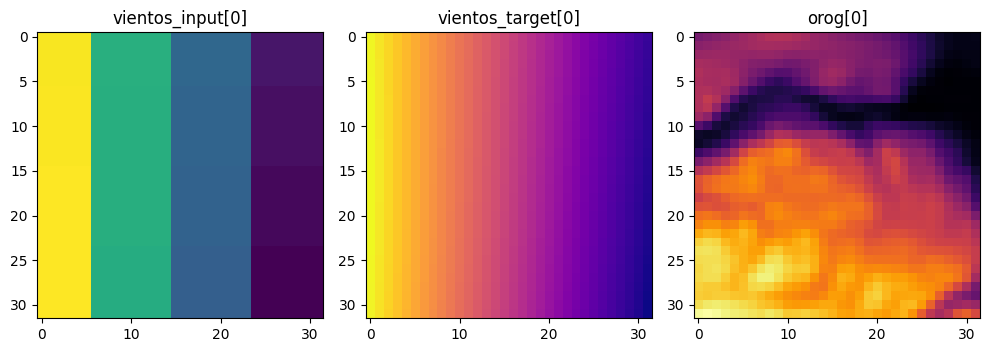

In [6]:
#| code-fold: true
#| label: visualizacion_parches
#| fig-cap: "Visualización del primer parche para el inp, target y orog"

i=0
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow( tf.squeeze(vientos_input)[1]  , cmap='viridis')
axs[0].set_title(f"vientos_input[{str(i)}]")

axs[1].imshow(tf.squeeze(vientos_target)[1] , cmap='plasma')
axs[1].set_title(f"vientos_target[{str(i)}]")

axs[2].imshow(tf.squeeze(orog)[1] , cmap='inferno')
axs[2].set_title(f"orog[{str(i)}]")

plt.tight_layout()
plt.show()

#### Caso especial: variable time2

Debido a que la variable ```times``` está importada como un valor constante y no como parches de tamaño (32,32), lo que haremos es expandir el valor importado a las dimensiones de los parches requeridos y luego repetimos este nuevo parche una cantidad igual a los 156 parches asociados a cada registro temporal (recordar que no existe variabilidad temporal al movernos en el espacio), para finalmente concatenar cada stack de parches temporales construidos:

In [7]:
stack_time= tf.zeros([1, 1, 32, 32, 1]) #inicializamos un stack con las dimensiones requeridas

for caso in casos:
    for i in range(120): 
        tiempo=  tf.fill([32, 32], stack[variables[-1]][caso][i].astype(np.float32) ) #llenamos un parche (32,32) con el registro temporal
        tiempo= tf.reshape(tiempo, [1, 1, 32, 32, 1]) #expandimos a las nuevas dimensiones requeridas
        tiempo=  tf.repeat(tiempo, 156, axis=0) # repetivos 156 veces el parche temporal creado
        stack_time=tf.concat( [stack_time, tiempo], axis=0) #concatenamos los parches creados para cada registro temporal

time2=stack_time[1:] #eliminamos el primer valor creado para inicializar el stack_time
print("Dimensiones tiempo: ",time2.shape)

Dimensiones tiempo:  (93600, 1, 32, 32, 1)


#### Normalización de los datos
Para favorecer el entrenamiento de la red, normalizaremos CADA VARIABLE en el rango $[0,1]$ utilizando la siguiente fórmula:
$$ \text{normalización(variable)} := \dfrac{variable - \min(variable)}{\max(variable) - \min(variable)}= \text{variable norm}$$
donde min(variable) y max(variable) corresponderán al mínimo y máximo valor de nuestra variable a normalizar respectivamente y serán guardados como factores de escalado para el proceso de desnormalización. 

In [8]:
def normalization( data_in=input,inverse=False, scale_factor=[1,1]):

    '''Método que normaliza los valores entregados.
    input:
        data_in: [tensor] Tensor con los parches de la variable que forma parte del input de la Red
        inverse: [Boolean, default=False] True en caso de devolver la transformación
    return: 
        variable normalizada
    '''
    if not inverse:
        scale_factor_ = np.max(np.abs(data_in))
        scale_factor_2 = np.min(np.abs(data_in))
        data_out = (data_in-scale_factor_2)/(scale_factor_ - scale_factor_2)
        scale_factor_ = [scale_factor_,scale_factor_2]
    else:
        data_out=(data_in * (scale_factor[0]-scale_factor[1]))+scale_factor[1]
        scale_factor_ = scale_factor
    return data_out, scale_factor_

input_norm, input_factor  = normalization(vientos_input)
target_norm,target_factor = normalization(vientos_target)
lat_norm   ,lat_factor    = normalization(lat)
lon_norm   ,lon_factor    = normalization(lon)
orog_norm  ,orog_factor   = normalization(orog)
time2_norm, time2_factor  = normalization(time2)

Ahora bien, en el trabajo original los parches contenian un corte temporal que agregaba el panorama de temperatura para el tiempo anterior y el tiempo siguiente. Sin embargo, ya que ahora estamos sobre un tiempo "discreto", resulta complicado utilizar este mismo procedimiento debido a la considerable diferencia temporal que existe entre cada caso. Lo anterior, sumado a la necesidad de compatilizar las dimensiones, incita a la replicación de los valores en la dimensión requerida 3 veces. En caso de que la red presente problemas de convergencia graves, se debería revisar esta suposición como prioridad.

In [9]:
input_norm_2 = tf.tile(input_norm,[1, 3, 1, 1, 1]) #repetimos en la segunda dimension 

comparacion_2= tf.reduce_all(tf.equal(input_norm[:,0,:,:,:], input_norm_2[:,1,:,:,:])) #comparacion valor por valor
if comparacion_2: 
    print("Los tensores son iguales")
else:
    print("Los tensores son diferentes")

Los tensores son iguales


In [10]:
input_norm = tf.tile(input_norm,[1, 3, 1, 1, 1]) #repetición de los valores de la dimensión
lat_norm = tf.tile(lat_norm, [1, 3, 1, 1, 1])
lon_norm = tf.tile(lon_norm, [1, 3, 1, 1, 1])
orog_norm = tf.tile(orog_norm, [1, 3, 1, 1, 1])
time2_norm = tf.tile(time2_norm, [1, 3, 1, 1, 1])
target_norm = tf.tile(target_norm, [1, 3, 1, 1, 1])

#### Guardado de los parches previa división incluyendo los factores de normalización (opcional)

In [14]:
#| code-fold: true
def guardado_parches(parches, nombre_parches, carpeta, opcional='', verbose=False):
    ruta_completa = os.path.join(carpeta, nombre_parches + opcional + '.npy')
    np.save(ruta_completa, parches)
    if verbose:
        print("Parches guardados exitosamente como: ", ruta_completa)

guardado_parches(input_norm, "inp_raw", "parches", "_27_03_24")
guardado_parches(lat_norm, "lat_raw", "parches", "_27_03_24")
guardado_parches(lon_norm, "lon_raw", "parches", "_27_03_24")
guardado_parches(orog_norm, "orog_raw", "parches", "_27_03_24")
guardado_parches(time2_norm, "time2_raw", "parches", "_27_03_24")
guardado_parches(target_norm, "target_raw", "parches", "_27_03_24")

guardado_parches(input_factor, "inp_factor", "parches", "_27_03_24")
guardado_parches(lat_factor, "lat_factor", "parches", "_27_03_24")
guardado_parches(lon_factor, "lon_factor", "parches", "_27_03_24")
guardado_parches(orog_factor, "orog_factor", "parches", "_27_03_24")
guardado_parches(time2_factor, "time2_factor", "parches", "_27_03_24")
guardado_parches(target_factor, "target_factor", "parches", "_27_03_24")

#### División de los datos

Finalmente la división de los datos se llevará a cabo sin tener ningún tipo de consideración espacial ni temporal específico para nuestra zona objetivo. Solo se reutilizará la misma función que fue implementada originalmente. Es importante destacar que, como el dominio a trabajar fue dividido en 156 cuadrantes y no en 12 como originalmente se hizo, la proporcionalidad en la cantidad de parches por cuadrante no tiene que ser por qué similiar. Sin embargo se espera, de una manera ideal, que cada cuadrante contenga aproximadamente una cantidad igual a $93600/156=600$ parches que serán divididos en 3 conjuntos: entrenamiento, validación y testeo, en una proporción de .60, .20, .20, respectivamente.

Por último se cambiará el .float32 de cada tensor por .float16, debido a que no se busca precisión sino eficiencia al correr el código. 

In [23]:
#| code-fold: true
def mysplit(inp, time, orog, lat, lon, target):
        ''' Método encargado de la división  de todas las variables que conforman el input de la red en: entrenamiento (60%), validación (20%) y testeo.
        return:
            división de cada variable en testeo, validación y testeo.
        '''
        data = tf.concat([tf.cast(inp, dtype=tf.float16),
                      tf.cast(time, dtype=tf.float16),
                      tf.cast(orog, dtype=tf.float16),
                      tf.cast(lat, dtype=tf.float16),
                      tf.cast(lon, dtype=tf.float16),
                      tf.cast(target, dtype=tf.float16)], axis=4)
        data = tf.random.shuffle(data, seed=10)
        n = data.shape[0]
        n_train = int(n * .6)
        n_valid = int(n * .2)
        n_test = n - n_train - n_valid
        data = tf.split(data, [n_train, n_valid, n_test])
        return (tf.expand_dims(data[0][:, :, :, :, 0],4),
            tf.expand_dims(data[0][:, :, :, :, 1],4),
            tf.expand_dims(data[0][:, :, :, :, 2],4),
            tf.expand_dims(data[0][:, :, :, :, 3],4),
            tf.expand_dims(data[0][:, :, :, :, 4],4),
            tf.expand_dims(tf.expand_dims(data[0][:,1,:,:,5],1),4),
            tf.expand_dims(data[1][:, :, :, :, 0],4),
            tf.expand_dims(data[1][:, :, :, :, 1],4),
            tf.expand_dims(data[1][:, :, :, :, 2],4),
            tf.expand_dims(data[1][:, :, :, :, 3],4),
            tf.expand_dims(data[1][:, :, :, :, 4],4),
            tf.expand_dims(tf.expand_dims(data[1][:,1,:,:,5],1),4),
            tf.expand_dims(data[2][:, :, :, :, 0],4),
            tf.expand_dims(data[2][:, :, :, :, 1],4),
            tf.expand_dims(data[2][:, :, :, :, 2],4),
            tf.expand_dims(data[2][:, :, :, :, 3],4),
            tf.expand_dims(data[2][:, :, :, :, 4],4),
            tf.expand_dims(tf.expand_dims(data[2][:,1,:,:,5],1),4))

In [24]:
(inp_tr,time_tr,orog_tr,lat_tr,lon_tr,target_tr,
 inp_va,time_va,orog_va,lat_va,lon_va,target_va,
 inp_te,time_te, orog_te,lat_te,lon_te, target_te) = mysplit(input_norm,time2_norm,orog_norm,lat_norm,lon_norm,target_norm)

#### Último ajuste: variable time2
Debido a que la variable temporal es una variable que se inserta en el espacio latente de la arquitectura de la red, ésta se debe integrar en tamaños de (4,4) en lugar de (32,32). Para cumplir con esto, tomaremos los primeros 4 valores de cada dimensión.

In [28]:
time_tr=time_tr[:,:,:4,:4,:]
time_va=time_va[:,:,:4,:4,:]
time_te=time_te[:,:,:4,:4,:]
print("Dimensiones time entrenamiento: ", time_tr.shape)

Dimensiones time entrenamiento:  (56160, 3, 4, 4, 1)


Visualización del resto de dimensiones

In [25]:
print("Dimensiones variables entrenamiento: ",inp_tr.shape)
print("Dimensiones variables validación: ",inp_va.shape)
print("Dimensiones variables testeo: ",inp_te.shape)

Dimensiones variables entrenamiento:  (56160, 3, 32, 32, 1)
Dimensiones variables validación:  (18720, 3, 32, 32, 1)
Dimensiones variables testeo:  (18720, 3, 32, 32, 1)


#### Guardado de parches (omitible)
Por último, guardaremos cada conjunto creado en una carpeta llamada ```parches``` que estará en el mismo directorio que el archivo con el cual estamos trabajando:

In [32]:
#| code-fold: true

guardado_parches(inp_tr, "inp_tr", "parches", "_27_03_24")
guardado_parches(inp_va, "inp_va", "parches", "_27_03_24")
guardado_parches(inp_te, "inp_te", "parches", "_27_03_24")

guardado_parches(target_tr, "target_tr", "parches", "_27_03_24")
guardado_parches(target_va, "target_va", "parches", "_27_03_24")
guardado_parches(target_te, "target_te", "parches", "_27_03_24")

guardado_parches(orog_tr, "orog_tr", "parches", "_27_03_24")
guardado_parches(orog_va, "orog_va", "parches", "_27_03_24")
guardado_parches(orog_te, "orog_te", "parches", "_27_03_24")

guardado_parches(lon_tr, "lon_tr", "parches", "_27_03_24")
guardado_parches(lon_va, "lon_va", "parches", "_27_03_24")
guardado_parches(lon_te, "lon_te", "parches", "_27_03_24")

guardado_parches(lat_tr, "lat_tr", "parches", "_27_03_24")
guardado_parches(lat_va, "lat_va", "parches", "_27_03_24")
guardado_parches(lat_te, "lat_te", "parches", "_27_03_24")

guardado_parches(time_tr, "time_tr", "parches", "_27_03_24")
guardado_parches(time_va, "time_va", "parches", "_27_03_24")
guardado_parches(time_te, "time_te", "parches", "_27_03_24", verbose=True)

Parches guardados exitosamente como:  parches\time_te_27_03_24.npy
